In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf

In [3]:
dt = 0.1
length = 100000
T = dt*length
D = 1.0
density =2
sigma = 1
# from these parameters we need to calculate over how much space
# we need to place particles
max_sig = np.sqrt(2*D*T+sigma**2)
L = max_sig*6 # six sigma may be enough, it may not - lets see
N = int(density*2*L)
print(N,' particles needed for T=',T)

3394  particles needed for T= 10000.0


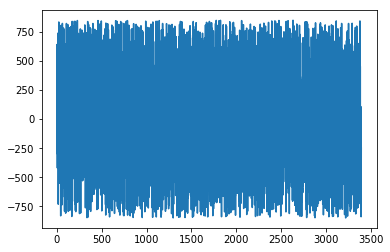

In [4]:
# generate positions for all particles
positions=2*L*np.random.random(size=(N,))-L
plt.plot(positions)

In [5]:
I = []
for i in range(length):
    intensities = (2*D*i*dt+sigma**2)/np.sqrt(2*np.pi)*np.exp(-positions**2/(2*(2*D*i*dt+sigma**2)))
    I.append(intensities.sum()-(2*D*i*dt+sigma**2)*np.sqrt(2*np.pi)*density)
I=np.array(I)

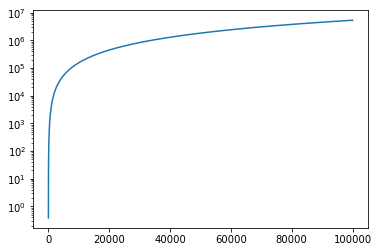

In [6]:
plt.semilogy(I)

In [7]:
# calculate paths
paths = np.mod(np.cumsum(x, axis=1),2*L)-L

NameError: name 'x' is not defined

In [ ]:
for path in paths:
    plt.plot(path,".")

In [ ]:
# place a Gaussian illumination at x=5.5 with unit variance
from scipy.stats import norm
intensity = norm.pdf(paths, loc=0)
#print(intensity)
intensity = np.sum(intensity, axis=0)
#print(intensity)

In [ ]:
plt.plot(intensity)
print(intensity.mean())
# what should it be
print(N/2/L)

In [ ]:
# calculate autocorrelation function
f = np.fft.rfft(intensity)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / length
autocorr = acf[int(length/2):]/intensity.mean()**2

autocorr = autocorr[:1000]-1.0
t = np.arange(0,autocorr.size)*dt
plt.semilogx(t,autocorr,"o")

In [ ]:
print(autocorr[0]/N*L)
print(L/autocorr[0]/N)
print(autocorr[0]*N/L*2*np.sqrt(np.pi))
print(L/autocorr[0]/N/np.sqrt(np.pi))

In [ ]:
# this is the model that describes the ideal case if infinite boundary conditions
def corrfit(t,N,D,gamma,w0):
    return 1/N/(1+(D*t/w0**2))**gamma

In [ ]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(t,N,D,w0,L):
    nmax = 20
    n = np.arange(1,nmax)
    nn,tt = np.meshgrid(n,t)
    
    efa = nn*np.pi*w0**2*1j
    an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    return np.sum(an,axis=1)/N/2

In [ ]:
corrfitPB_model=lm.Model(corrfitPB)
paramsPB = corrfitPB_model.make_params()
paramsPB['w0'].set(value=1,vary=False)
paramsPB['N'].set(value=20,vary=True)
paramsPB['D'].set(value=D,vary=True)
paramsPB['L'].set(value=L,vary=False)

resultPB = corrfitPB_model.fit(t=t,data=autocorr,params=paramsPB)

In [ ]:
print(resultPB.fit_report())

In [ ]:
corrfit_model=lm.Model(corrfit)
params = corrfit_model.make_params()
params['w0'].set(value=1,vary=False)
params['N'].set(value=5,vary=True)
params['D'].set(value=1,vary=True)
params['gamma'].set(value=0.5,vary=False)

result = corrfit_model.fit(t=t,data=autocorr,params=params)

In [ ]:
print(result.fit_report())

In [ ]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, result.init_fit, 'k--')
plt.semilogx(t, result.best_fit, 'r-')

In [ ]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, resultPB.init_fit, 'k--')
plt.semilogx(t, resultPB.best_fit, 'r-')